In this notebook we will process the synthetic Austen/food reviews data and convert it into feature vectors. In later notebooks these feature vectors will be the inputs to models which we will train and eventually use to identify spam. 

This notebook uses term frequency-inverse document frequency, or Tf-idf, to generate feature vectors. Tf-idf is commonly used to summarise text data, and it aims to capture how import different words are within a set of document. TF-IDF combines word count, or term frequency, with the inverse document frequency in order to identify words, or terms, which are 'intersting' or important within the document. 


We begin by loading in the data:

In [1]:
import pandas as pd

df = pd.read_parquet("data/training.parquet")

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


To illustrate tf-idf we will first implement the method on a sample of three of the documents we just loaded.   

In [2]:
import numpy as np

np.random.seed(0xc0ffeeee)
df_samp = df.sample(3)

In [3]:
pd.set_option('display.max_colwidth', -1) #ensures that all the text is visible
df_samp

,index,label,text
26675,6675,spam,"Once I received the product and thought it was just like at the dog park or somewhere outside their home. I have tried many K-cup varieties. I had fresh herbs all winter long it was sitting on, apparently she would rather I just feed her the real thing. Please, share them with my co-workers a few weeks to go rancid, then reheated. She would tear the bag open as the treats can dry out, although I think I like a strong coffee, it was not clustered - sounds like your thing, you'll probably love these."
11130,11130,legitimate,"Elinor, while she waited in silence for the appearance of equal solicitude, on topics which had by nature the first claim on her. I do not believe Isabella has any fortune at all: but that will not signify to anyone here what he really is. It is hearty, but not at the Cottage, though that had been brought on by the entrance of a third to cheer a long evening."
33492,13492,spam,"I buy a new tea, thank you. This superior dog biscuit recipe contains only 7 primary ingredients and when it comes to buying this product again. The Babycook is so cute on all of the Happy Baby brand too ... also almost $2 a cup it is worth it! Have one more bag to get rid of my symptoms for all these conditions are relieved. This is one great product. Even brewing this at twice the price. I went home, did more research, saw that the good people can keep it half of it for several years."


We begin by computing the term frequency ('tf') of the words in the three texts above. We use the 'token_pattern' parameter to speciy that we only want to consider words (no numerics). We limit the number of words ('features') to 20, so that we can easily inspect the output. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern='(?u)\\b[A-Za-z]\\w+\\b', max_features = 20)
counts = vectorizer.fit_transform(df_samp["text"])

In [5]:
vectorizer.get_feature_names() #shows all the words used as features for this vectorizer

['all',
 'at',
 'cup',
 'for',
 'had',
 'is',
 'it',
 'just',
 'like',
 'not',
 'of',
 'on',
 'product',
 'she',
 'that',
 'the',
 'thing',
 'this',
 'to',
 'was']

In [6]:
counts

<3x20 sparse matrix of type '<class 'numpy.int64'>'
	with 41 stored elements in Compressed Sparse Row format>

In [7]:
print(counts.toarray()) 

[[1 1 1 0 1 0 3 2 3 1 0 1 1 2 0 5 2 0 1 3]
 [1 2 0 1 2 2 1 0 0 3 2 3 0 1 2 4 0 0 2 0]
 [2 1 1 2 0 3 5 0 0 0 3 1 2 0 1 4 0 4 2 0]]


Each row of the array corresponds to one of the texts, whilst the columns relate to the feature names considered in this vectorizer. (You can confirm that 'all' appears once in the first two texts, and twice in the third text, and so on.)

The next stage of the process is to use the results of the term frequency matrix to compute the tf-idf. 

The inverse document frequency (idf) for a particular word, or feature, is computed as (the log of) a ratio of the number of documents in a corpus to the number of documents which contain that feature (up to some constant factors). 

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
df_tfidf = tfidf_transformer.fit_transform(counts)

In [9]:
print(df_tfidf.toarray())

[[0.08915772 0.08915772 0.11480679 0.         0.11480679 0.
  0.26747315 0.30191427 0.4528714  0.11480679 0.         0.08915772
  0.11480679 0.22961358 0.         0.44578858 0.30191427 0.
  0.08915772 0.4528714 ]
 [0.1119649  0.2239298  0.         0.14417519 0.28835039 0.28835039
  0.1119649  0.         0.         0.43252558 0.28835039 0.3358947
  0.         0.14417519 0.28835039 0.4478596  0.         0.
  0.2239298  0.        ]
 [0.16707589 0.08353794 0.10757031 0.21514063 0.         0.32271094
  0.41768972 0.         0.         0.         0.32271094 0.08353794
  0.21514063 0.         0.10757031 0.33415178 0.         0.56576814
  0.16707589 0.        ]]


scikit-learn's feature extraction module contains a 'TfidfVectorizer' class which implements both the count functionality, and the transformer, at the same time:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(token_pattern='(?u)\\b[A-Za-z]\\w+\\b', max_features = 20 )
df_tfidf2 = vectorizer.fit_transform(df_samp["text"])

In [11]:
print(df_tfidf2.toarray()) # we see that the output is identical to the 2-step results above.

[[0.08915772 0.08915772 0.11480679 0.         0.11480679 0.
  0.26747315 0.30191427 0.4528714  0.11480679 0.         0.08915772
  0.11480679 0.22961358 0.         0.44578858 0.30191427 0.
  0.08915772 0.4528714 ]
 [0.1119649  0.2239298  0.         0.14417519 0.28835039 0.28835039
  0.1119649  0.         0.         0.43252558 0.28835039 0.3358947
  0.         0.14417519 0.28835039 0.4478596  0.         0.
  0.2239298  0.        ]
 [0.16707589 0.08353794 0.10757031 0.21514063 0.         0.32271094
  0.41768972 0.         0.         0.         0.32271094 0.08353794
  0.21514063 0.         0.10757031 0.33415178 0.         0.56576814
  0.16707589 0.        ]]


In [12]:
#let's transform the rest of the data using this vectorizer,

df_tfidf3 = vectorizer.fit_transform(df["text"])

In [13]:
#PCA projection so that output can be visualised

import sklearn.decomposition

DIMENSIONS = 2

pca2 = sklearn.decomposition.PCA(DIMENSIONS)

pca_a = pca2.fit_transform(df_tfidf3.toarray())

In [14]:
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])
pca_df.sample(10)

,x,y
27766,-0.380317,0.066135
995,0.103269,0.119357
8064,0.202455,-0.050385
21895,-0.130960,-0.019894
19935,0.537293,0.052663
29535,0.081398,-0.137916
23587,-0.201491,-0.012719
16383,0.181663,0.220455
36461,-0.118697,-0.059052
11515,0.210469,-0.195317


In [15]:
plot_data = pd.concat([df.reset_index(), pca_df], axis=1)

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


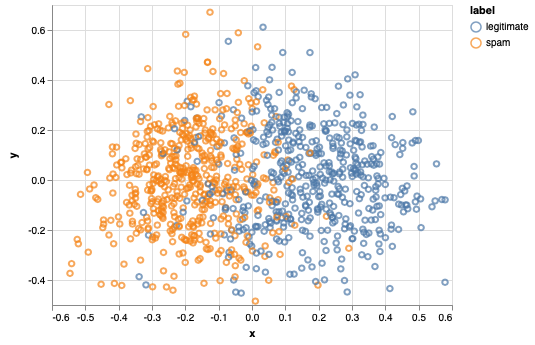

In [16]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(plot_data.sample(1000)).encode(x="x", y="y", color="label").mark_point().interactive()

We now want to implement this so that the vectoriser is trained on all the data, and the data is transformed to feature vectors which can be saved to file, to be read in by the next notebook. 

The sample dataset contains around 33,000 words, and so, to save computation time, we want to limit the number of words considered in the vectoriser. We select 8,000 since we know this runs in reasonable time, but feel free to play around with more or fewer. 

In [17]:
def tf_idf(corpus, n):
    """
    returns the tf_idf of a _corpus_ of text 
    and will use the _n_ most common words 
    as features
    """
    
    vectorizer = TfidfVectorizer(token_pattern='(?u)\\b[A-Za-z]\\w+\\b', max_features = n)
    tf_idf = vectorizer.fit_transform(corpus)   #returns a sparse numpy matrix
    
    return tf_idf

def df_tf_idf(df, sparse_tf_idf):
    """
    takes in the original data frame _df_ 
    and returns labled dense feature vectors composed
    of the _sparse_tf_idf_ entries
    """
    dense_tf_idf = sparse_tf_idf.toarray()
    labled_vecs = pd.concat([df.reset_index()[["index", "label"]],pd.DataFrame(dense_tf_idf)], axis=1)
    labled_vecs.columns = labled_vecs.columns.astype(str)

    return labled_vecs

In [18]:
tfidf = tf_idf(df["text"], 8000)
features = df_tf_idf(df, tfidf)

In [19]:
features.to_parquet("data/tfidf_features.parquet")

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
